In [1]:
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from astropy.table import Table

In [77]:
from ipydatagrid import DataGrid
import pandas as pd
import ipywidgets as widgets
from ipydatagrid import DataGrid, TextRenderer

# Query the Kepler exoplanet data from the new 'ps' table
kepler_data = NasaExoplanetArchive.query_criteria(table="pscomppars", select="*", where="disc_facility='Kepler'")

# Convert to an Astropy Table
kepler_data = Table(kepler_data)

kepler_table_df = pd.DataFrame(np.array(kepler_data))
kepler_table = DataGrid(kepler_table_df, editable=False, layout={'height':'200px'})

# Filter the DataFrame to include only the necessary columns
filtered_kepler_table_df = kepler_table_df[['hostname', 'sy_pnum', 'pl_orbper', 'st_met', 'pl_name', 'gaia_id']]

# Create a new DataGrid for the filtered table
filtered_kepler_table = DataGrid(filtered_kepler_table_df, editable=False, layout={'height':'200px'})

# Create a search box
search_box = widgets.Text(
    value='',
    placeholder='Search for hostname',
    description='Search:',
    disabled=False
)

# Function to filter the DataFrame based on the search input
def filter_table(change):
    search_value = change['new']
    if search_value:
        df = filtered_kepler_table_df[filtered_kepler_table_df['hostname'].str.contains(search_value, case=False, na=True)]
    else:
        df = filtered_kepler_table_df
    filtered_kepler_table.data = df

# Attach the filter function to the search box
search_box.observe(filter_table, names='value')

# Display the search box and the new DataGrid
display(search_box, filtered_kepler_table)


Text(value='', description='Search:', placeholder='Search for hostname')

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [78]:


kepler_table

DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [79]:
def check_and_replace_st_met(df):
    # Group by hostname
    grouped = df.groupby('hostname')
    
    for name, group in grouped:
        # Get unique st_met values, excluding NaNs
        unique_met_values = group['st_met'].dropna().unique()
        
        if len(unique_met_values) > 1:
            # Check if all values are within 0.01 of each other
            if np.all(np.abs(unique_met_values - unique_met_values.mean()) <= 0.01):
                # Average the values
                avg_met_value = unique_met_values.mean()
                df.loc[df['hostname'] == name, 'st_met'] = avg_met_value
            else:
                print(f"Warning: Discrepancy in st_met values for {name}: {unique_met_values}")
        
        # Replace NaNs with the first available st_met value
        if len(unique_met_values) > 0:
            df.loc[df['hostname'] == name, 'st_met'] = df.loc[df['hostname'] == name, 'st_met'].fillna(unique_met_values[0])
    
    return df

# Filter out systems with one star that have more than one metallicity value
def filter_discrepant_monostar_systems(df):
    grouped = df.groupby('hostname')
    to_remove = []
    
    for name, group in grouped:
        if group['sy_snum'].iloc[0] == 1:  # Only consider monostar systems
            unique_met_values = group['st_met'].dropna().unique()
            if len(unique_met_values) > 1 and not np.all(np.abs(unique_met_values - unique_met_values.mean()) <= 0.01):
                to_remove.append(name)
    
    return df[~df['hostname'].isin(to_remove)]


I listened to David Rice's talk today and I am wondering if there is a connection between metalicity and gap complexity.


In [80]:
# Select relevant columns and filter for multiplicity between 3 and 8
filtered_kepler_table_df = kepler_table_df[['pl_name', 'hostname', 'st_met', 'sy_pnum', 'sy_snum', 'pl_orbper']]
# Apply the function to check and replace st_met values
filtered_kepler_table_df = check_and_replace_st_met(filtered_kepler_table_df)
filtered_kepler_table_df = filter_discrepant_monostar_systems(filtered_kepler_table_df)
filtered_kepler_table_df = filtered_kepler_table_df.dropna(subset=['st_met'])
filtered_kepler_table_df = filtered_kepler_table_df[(filtered_kepler_table_df['sy_pnum'] >= 3) & (filtered_kepler_table_df['sy_pnum'] <= 8)]

# Split into different DataFrames based on the number of stars (sy_snum)
monostar_systems_df = filtered_kepler_table_df[filtered_kepler_table_df['sy_snum'] == 1]
duostar_systems_df = filtered_kepler_table_df[filtered_kepler_table_df['sy_snum'] == 2]
tristar_systems_df = filtered_kepler_table_df[filtered_kepler_table_df['sy_snum'] == 3]

# Create a DataGrid for the filtered table with custom column widths
column_widths = {
    'pl_name': 150,
    'hostname': 150,
    'st_met': 100,
    'sy_pnum': 100,
    'sy_snum': 100,
    'pl_orbper': 100
}

# Create a DataGrid for the filtered table
filtered_kepler_table_grid = DataGrid(filtered_kepler_table_df, editable=False, layout={'height':'200px'}, column_widths=column_widths)

print(f"Number of rows: {filtered_kepler_table_df.shape[0]}")
filtered_kepler_table_grid

Number of rows: 540


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, column_widths={'pl_name': 150, 'host…

In [81]:
# Create a DataGrid for the filtered table
monostar_systems_grid = DataGrid(monostar_systems_df, editable=False, layout={'height':'200px'}, column_widths=column_widths)
print(f"Number of rows: {monostar_systems_df.shape[0]}")
monostar_systems_grid

Number of rows: 484


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, column_widths={'pl_name': 150, 'host…

In [82]:
# Create a DataGrid for the filtered table
duostar_systems_grid = DataGrid(duostar_systems_df, editable=False, layout={'height':'200px'}, column_widths=column_widths)
print(f"Number of rows: {duostar_systems_df.shape[0]}")
duostar_systems_grid

Number of rows: 51


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, column_widths={'pl_name': 150, 'host…

In [83]:
# Create a DataGrid for the filtered table
tristar_systems_grid = DataGrid(tristar_systems_df, editable=False, layout={'height':'200px'}, column_widths=column_widths)
print(f"Number of rows: {tristar_systems_df.shape[0]}")
tristar_systems_grid

Number of rows: 5


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, column_widths={'pl_name': 150, 'host…

In [84]:
# Get unique star names for each DataFrame
unique_monostar_names = monostar_systems_df['hostname'].unique().tolist()
unique_duostar_names = duostar_systems_df['hostname'].unique().tolist()
unique_tristar_names = tristar_systems_df['hostname'].unique().tolist()

# Display the unique star names
unique_star_names = [unique_monostar_names, unique_duostar_names, unique_tristar_names]

for i, names in enumerate(unique_star_names):
    print(f"\n{len(unique_star_names[i])} Unique star names in {i+1} systems:")
    print(names)



142 Unique star names in 1 systems:
['Kepler-276', 'Kepler-169', 'Kepler-11', 'Kepler-219', 'Kepler-10', 'Kepler-107', 'Kepler-32', 'KOI-142', 'Kepler-30', 'Kepler-129', 'Kepler-102', 'Kepler-334', 'Kepler-126', 'Kepler-166', 'Kepler-51', 'Kepler-106', 'Kepler-265', 'Kepler-80', 'Kepler-286', 'Kepler-279', 'Kepler-82', 'Kepler-247', 'Kepler-42', 'Kepler-325', 'Kepler-306', 'Kepler-299', 'Kepler-295', 'Kepler-84', 'Kepler-100', 'Kepler-221', 'Kepler-79', 'Kepler-446', 'Kepler-81', 'Kepler-31', 'Kepler-288', 'Kepler-401', 'Kepler-206', 'Kepler-298', 'Kepler-250', 'Kepler-154', 'Kepler-184', 'Kepler-235', 'Kepler-160', 'Kepler-150', 'Kepler-354', 'Kepler-207', 'Kepler-249', 'Kepler-55', 'Kepler-33', 'Kepler-450', 'Kepler-49', 'Kepler-305', 'Kepler-220', 'Kepler-62', 'Kepler-92', 'Kepler-149', 'Kepler-23', 'Kepler-56', 'Kepler-85', 'Kepler-289', 'Kepler-114', 'Kepler-1254', 'Kepler-142', 'Kepler-603', 'Kepler-24', 'Kepler-1542', 'Kepler-203', 'Kepler-127', 'Kepler-223', 'Kepler-208', 'Kep

In [85]:
# Define a function to calculate the gap complexity for a given planetary system
from typing import List
import numpy as np

def gap_complexity(n: int, periods: List[float]) -> float:
    ''' 
    Calculate the gap complexity for a given planetary system.

    INPUTS
    ------
    n : int
        Number of planets in the system
    periods : List[float]
        Array of planet periods in increasing order

    OUTPUTS
    -------
    C : float
        Gap complexity of the system
    
    NOTES
    -----
    For planet periods, Gilbert & Fabrycky (2020) define gap complexity as:

    .. math::

        C = -K \left( \sum_{i=1}^{n-1} p_i^* \ln p_i^* \right) \left( \sum_{i=1}^{n-1} \left(p_i^* - \frac{1}{n-1}\right)^2 \right),

    .. math::

        p_i^* = \frac{\ln(P_{i+1}/P_i)}{\ln(P_n/P_1)},

    where `n` is the number of planets in the system, the ratio of periods for each adjacent planet pair is `P_{i+1}/P_i`, and the outermost and innermost planet periods are `P_n` and `P_1`. `K` is the normalization constant, which varies based on planet multiplicity and is given as `K=1/C_{max}`, where `C_{max}=[0.105, 0.212, 0.291, 0.350, 0.398, 0.437]`, respectively, for each multiplicity from 3- to 8-planet.
    '''
    
    # Calculate K based on stellar multiplicity
    C_max = np.array([0.105, 0.212, 0.291, 0.350, 0.398, 0.437])
    multiplicity = np.arange(3, 9)
    keyed_K = dict(zip(multiplicity, 1.0 / C_max))
    K = keyed_K[n]

    # Calculate pi_star
    pi_stars = np.zeros(n - 1)
    for i in range(n - 1):
        pi_stars[i] = np.log(periods[i + 1] / periods[i]) / np.log(periods[-1] / periods[0])

    # Calculate gap complexity (C)
    C = -K * np.sum(pi_stars * np.log(pi_stars)) * np.sum((pi_stars - 1 / (n - 1)) ** 2)  

    return C

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_51278/2237320778.py:6: SyntaxWarning: invalid escape sequence '\l'
  '''


In [86]:
# Initialize a dictionary to store the results
gap_complexity_results = []

# Calculate gap complexity for each star system
for star in unique_monostar_names:
    # Extract the periods for the current star system
    star_system = monostar_systems_df[monostar_systems_df['hostname'] == star]
    periods = star_system['pl_orbper'].values
    metallicity = star_system['st_met'].values[0]  # Assuming metallicity is the same for all entries of the same star

    # Sort the periods in increasing order
    periods = np.sort(periods)
    
    # Get the number of planets in the system
    n = star_system['sy_pnum'].values[0]
    
    # Check if the number of periods matches the number of planets
    if len(periods) != n:
        print(f"Skipping star {star} due to mismatch in number of periods and planets.")
        continue
    
    # Calculate the gap complexity
    C = gap_complexity(n, periods)
    
    # Store the result
    gap_complexity_results.append({'Star': star, 'Gap Complexity': C, 'Metallicity': metallicity})

# Convert the results to a DataFrame for better readability
monostar_gap_complexity_df = pd.DataFrame(gap_complexity_results)


# Define custom column widths
column_widths = {
    'Star': 200,
    'Gap Complexity': 200,
    'Metallicity': 200
}

# Create a DataGrid for the gap complexity results
gap_complexity_grid = DataGrid(monostar_gap_complexity_df, editable=False, layout={'height': '400px'}, column_widths=column_widths)

# Display the DataGrid
display(gap_complexity_grid)

Skipping star Kepler-10 due to mismatch in number of periods and planets.
Skipping star KOI-142 due to mismatch in number of periods and planets.
Skipping star Kepler-129 due to mismatch in number of periods and planets.
Skipping star Kepler-82 due to mismatch in number of periods and planets.
Skipping star Kepler-100 due to mismatch in number of periods and planets.
Skipping star Kepler-56 due to mismatch in number of periods and planets.
Skipping star Kepler-138 due to mismatch in number of periods and planets.
Skipping star Kepler-139 due to mismatch in number of periods and planets.
Skipping star Kepler-65 due to mismatch in number of periods and planets.
Skipping star Kepler-48 due to mismatch in number of periods and planets.


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, column_widths={'Star': 200, 'Gap Com…

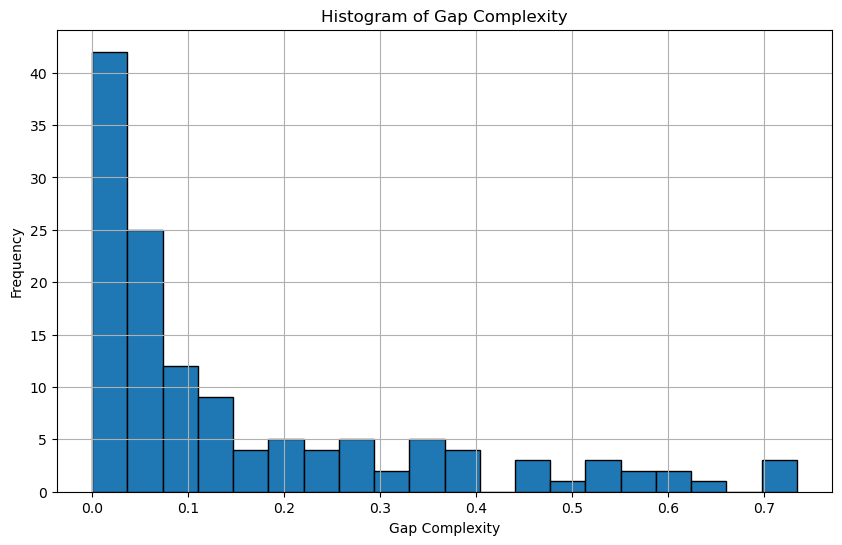

In [87]:
# Extract the gap complexity values
gap_complexity_values = monostar_gap_complexity_df['Gap Complexity']

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(gap_complexity_values, bins=20, edgecolor='black')
plt.title('Histogram of Gap Complexity')
plt.xlabel('Gap Complexity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [49]:
# Initialize a dictionary to store the results
gap_complexity_results = []

# Extract unique star names for tristar systems
unique_tristar_names = tristar_systems_df['hostname'].unique()

# Calculate gap complexity for each tristar system
for star in unique_tristar_names:
    # Extract the periods for the current star system
    star_system = tristar_systems_df[tristar_systems_df['hostname'] == star]
    periods = star_system['pl_orbper'].values
    metallicity = star_system['st_met'].values[0]  # Assuming metallicity is the same for all entries of the same star

    # Sort the periods in increasing order
    periods = np.sort(periods)
    
    # Get the number of planets in the system
    n = star_system['sy_pnum'].values[0]
    
    # Check if the number of periods matches the number of planets
    if len(periods) != n:
        print(f"Skipping star {star} due to mismatch in number of periods and planets.")
        continue
    
    # Calculate the gap complexity
    C = gap_complexity(n, periods)
    
    # Store the result
    gap_complexity_results.append({'Star': star, 'Gap Complexity': C, 'Metallicity': metallicity})

# Convert the results to a DataFrame for better readability
tristar_gap_complexity_df = pd.DataFrame(gap_complexity_results)

# Display the results
print(tristar_gap_complexity_df)

         Star  Gap Complexity  Metallicity
0  Kepler-444        0.022968        -0.55
